# Modules, Styling, & Helpful Functions

In [1]:
import warnings; warnings.filterwarnings("ignore")
import numpy as np,pandas as pd
import pylab as pl,seaborn as sn
import scipy as sp,keras as ks
import statsmodels.api as sm
from statsmodels.tsa import ar_model
from IPython.display import display,HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error,mean_absolute_error
from sklearn.metrics import r2_score,explained_variance_score

Using TensorFlow backend.


In [2]:
thp=[('font-size','16px'),('text-align','center'),
     ('font-weight','bold'),('padding','5px 5px'),
     ('color','#66FF66'),('background-color','slategray')]
tdp=[('font-size','14px'),('padding','5px 5px'),
     ('text-align','center'),('color','darkgreen'),
     ('background-color','silver')]
style_dict=[dict(selector='th',props=thp),
            dict(selector='td',props=tdp)]
pl.style.use('seaborn-pastel')
pl.style.use('seaborn-whitegrid')

In [3]:
def reg_plot(targets,preds):
    pl.figure(figsize=(11,6))
    mse=mean_squared_error(targets,preds)
    pl.plot(targets,'o',label='real data',
            markersize=3,markeredgecolor='darkgreen',
            markerfacecolor="None",markeredgewidth=1)
    pl.plot(preds,'o',label='predictions',
            markersize=3,markeredgecolor='#66ff66',
            markerfacecolor="None",markeredgewidth=1)
    pl.legend(); pl.title('mse = %.6f'%mse);

# Data Loading & Exploration

In [4]:
c_bank=pd.read_csv('../input/c_bank.csv')
finance=c_bank.drop(['date','monetary_gold',
                     'foreign_exchange_reserves'],1)
metal_list=['silver','palladium','platinum','gold']
dual_metal_list=['dual_currency_basket','silver',
                 'palladium','platinum','gold']
display(c_bank.head().T.style\
        .set_table_styles(style_dict))
finance.describe().T.style.set_table_styles(style_dict)

,0,1,2,3,4
date,2012-01-11,2012-01-12,2012-01-13,2012-01-14,2012-01-17
monetary_gold,44697,44697,44697,44697,44697
foreign_exchange_reserves,453952,453952,453952,453952,453952
gold,1667.25,1671.87,1683.17,1667.31,1687.4
silver,29.56,30.25,30.36,31.05,30.43
platinum,1495.09,1512.93,1527.84,1505.86,1528.78
palladium,648.66,653.06,652.9,641.74,657.1
dual_currency_basket,35.8717,35.6115,35.5527,35.6492,35.7368
EUR_978,40.7591,40.4061,40.2852,40.6189,40.3842
USD_840,31.8729,31.6886,31.6807,31.583,31.9344


,count,mean,std,min,25%,50%,75%,max
gold,1128,1861.92,478.427,1255.16,1492.95,1666.54,2263.28,3167.94
silver,1128,28.4857,5.19472,19.57,23.16,28.715,32.265,43.38
platinum,1128,1763.61,292.316,1392.06,1547.05,1643.36,1975.06,2746.69
palladium,1128,969.002,295.731,575.07,707.353,904.585,1235.65,1745.69
dual_currency_basket,1128,48.4637,15.0178,33.3027,35.7257,40.592,65.0453,87.0068
EUR_978,1128,53.6298,14.4745,38.4117,40.6308,47.5407,69.0225,91.1814
USD_840,1128,44.2369,15.5302,28.9468,31.8049,35.0177,61.5123,83.5913
JPY_392,1128,0.424878,0.104487,0.303766,0.339642,0.390938,0.510391,0.713937
CNY_156,1128,7.0272,2.34687,4.58527,5.08861,5.68993,9.65838,12.705
INR_356,1128,0.721547,0.202945,0.487974,0.566931,0.591285,0.950407,1.23046


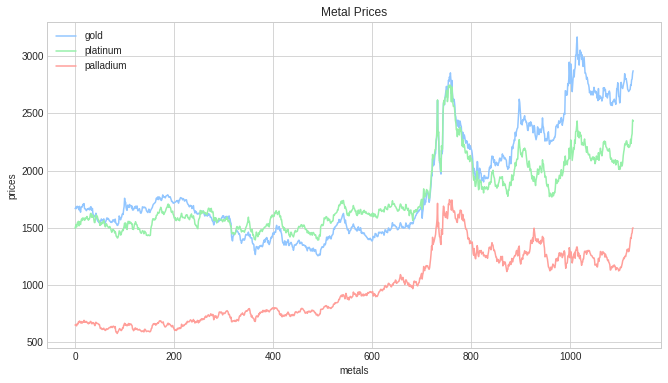

In [5]:
pl.figure(figsize=(11,6))
c_bank.gold.plot()
c_bank.platinum.plot()
c_bank.palladium.plot()
pl.xlabel('metals'); pl.ylabel('prices')
pl.title('Metal Prices')
pl.legend(['gold','platinum','palladium']);

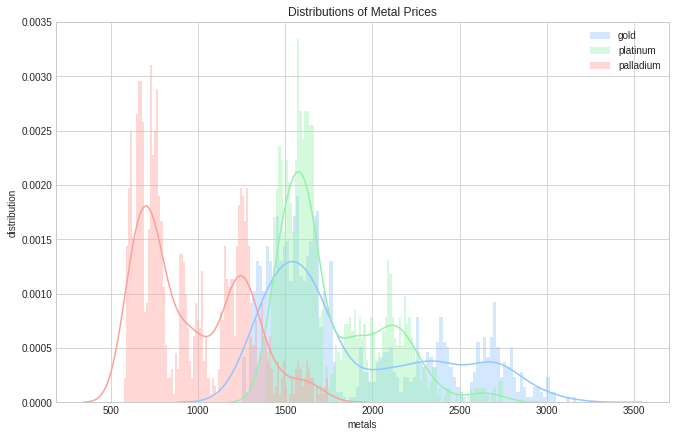

In [6]:
pl.figure(figsize=(11,7))
sn.distplot(c_bank.gold,bins=100)
sn.distplot(c_bank.platinum,bins=100)
sn.distplot(c_bank.palladium,bins=100)
pl.xlabel('metals')
pl.ylim(0.,.0035); pl.ylabel('distribution')
pl.title('Distributions of Metal Prices')
pl.legend(['gold','platinum','palladium']);

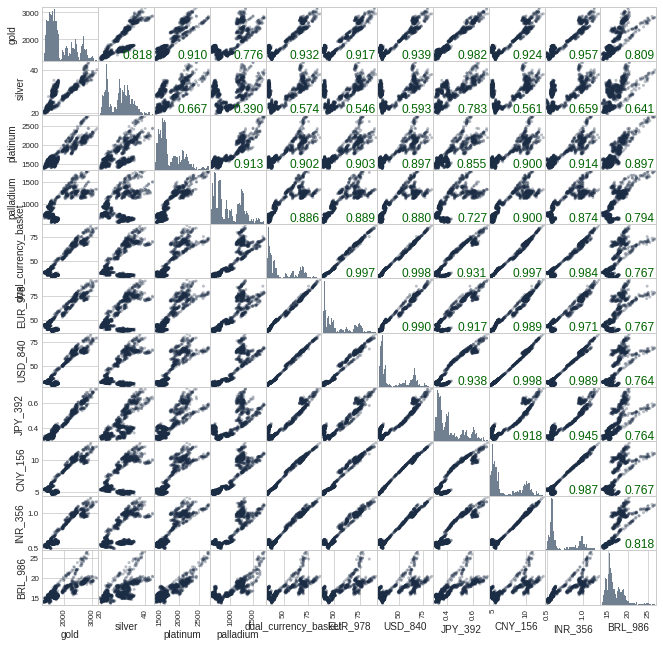

In [7]:
hd={'color':'SlateGrey','bins':50}
axes=pd.plotting.scatter_matrix(finance,alpha=.3,
                                figsize=(11,11),diagonal='hist',
                                c='#1b2c45',hist_kwds=hd)
corr=finance.corr().as_matrix()
for i,j in zip(*np.triu_indices_from(axes,k=1)):
    axes[i,j].annotate("%.3f"%corr[i,j],(.7,.1),fontsize=12,
                       color='darkgreen',xycoords='axes fraction',
                       ha='center',va='center');

In [8]:
features=RobustScaler().fit_transform(finance[metal_list])
targets=RobustScaler().fit_transform(finance['dual_currency_basket']\
                     .values.reshape(-1,1))
X_train,X_test=features[:850],features[850:]
y_train,y_test=targets[:850],targets[850:]

# Models
#### `Numpy Solutions` (the least-squares solution to a linear matrix equation) & `OLS Model`

[-0.40278793  0.19084104 -0.10701622  1.04512518]
rmse = 0.073379
[-0.40278793  0.19084104 -0.10701622  1.04512518]
r2 = 0.983889


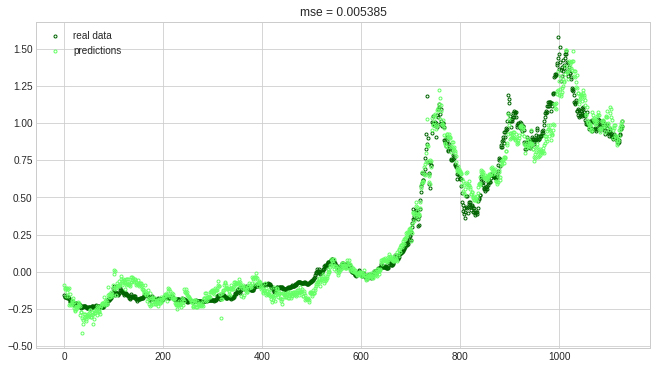

In [9]:
coef,total_error,_,_=np.linalg.lstsq(features,targets)
rmse=np.sqrt(total_error[0]/len(targets))
preds=np.dot(features,coef); n=len(targets)
print(coef.reshape(-1)); print('rmse = %.6f'%rmse)
ols_model=sm.OLS(targets,features)
ols_results=ols_model.fit()
ols_preds=ols_results.predict(features)
ols_coef=ols_results.params
ols_r2=ols_results.rsquared
print(ols_coef); print('r2 = %.6f'%ols_r2)
reg_plot(targets,ols_preds)

#### Structural time series models

In [10]:
data=c_bank[dual_metal_list]
ids=[pd.Timestamp(c_bank['date'][i]) for i in range(n)]
data=data.set_index(c_bank['date'].values)
restricted_model={'level':'smooth trend','cycle': True,
                  'damped_cycle': True,'stochastic_cycle':True}
dual_restricted_mod=sm.tsa\
.UnobservedComponents(data['dual_currency_basket'],**restricted_model)
dual_restricted_res=dual_restricted_mod.fit(method='powell',disp=False)
print(dual_restricted_res.summary())

                            Unobserved Components Results                            
Dep. Variable:          dual_currency_basket   No. Observations:                 1128
Model:                          smooth trend   Log Likelihood               -1409.869
                   + damped stochastic cycle   AIC                           2829.738
Date:                       Sat, 09 May 2020   BIC                           2854.879
Time:                               11:53:55   HQIC                          2839.237
Sample:                           01-11-2012                                         
                                - 07-30-2016                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.1351      0.013     10.214      0

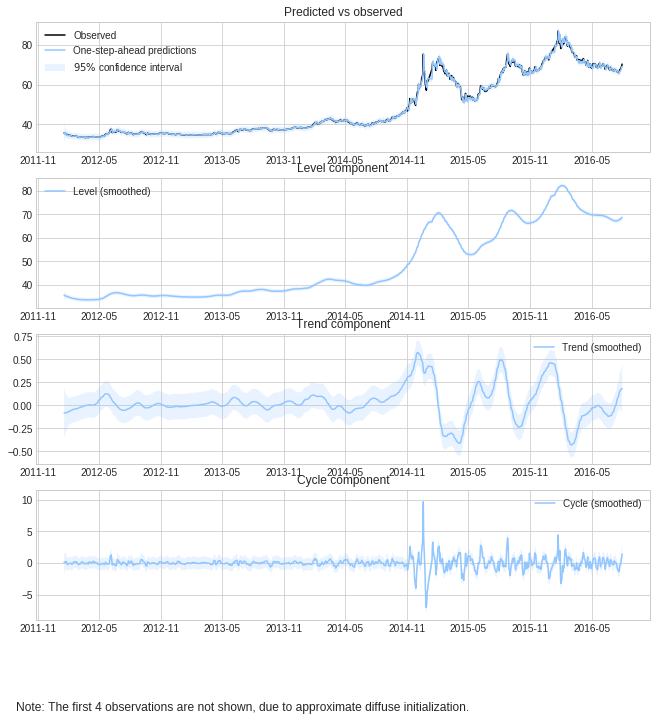

In [11]:
fig=dual_restricted_res\
.plot_components(legend_loc='higher left',figsize=(11,11));